In [0]:
import warnings 
warnings.filterwarnings('ignore')
import numpy as np 
import pandas as pd 
%matplotlib inline
import matplotlib.pyplot as plt  # Matlab style plot
import seaborn as sns # affichage, on peut utiliser d'autres librairies
import statsmodels.api as sm # modèle stat contenant le modèle ARIMA
from pylab import *
from scipy import stats
from scipy.stats import normaltest

color = sns.color_palette()
sns.set_style('darkgrid')


In [0]:
ls

TP1_eleves.ipynb                        consommation-quotidienne-brute_tr1.csv
TP1_eleves_corrigés.ipynb               donneesTP2/
TP1_eleves_corrigés.ipynb.txt           donneesTP2.zip
TP2_eleves.ipynb                        serie_temporelle_C1_20200114.pdf
TP2_eleves_corriges-2.ipynb             serie_temporelle_C2_20200114.pdf
TP2_eleves_corriges.ipynb


## Utils

In [0]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

In [0]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    series = tf.expand_dims(series, axis=-1)
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size + 1))
    ds = ds.shuffle(shuffle_buffer)
    ds = ds.map(lambda w: (w[:-1], w[1:]))
    return ds.batch(batch_size).prefetch(1)

In [0]:
def model_forecast(model, series, window_size):
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size))
    ds = ds.batch(32).prefetch(1)
    forecast = model.predict(ds)
    return forecast

In [0]:
def build_MLP( input_shape, activation = 'relu', units = [100,100], momentum=0.1, epsilon=1e-05, dropout_rate = 0,
              optimizer = 'Adam', loss = 'binary_crossentropy', metrics = ['accuracy']):
    
    """
    build a neural network with linear blocks fellowed by non linear activations. Every block consists of
     BatchNormalization, Dropout and a  dense layer. The depth of the network can be custumized in parameter "units"


  	Parameters:
    ----------

  	input_shape : tuple of integers.
        Correspond to the shape of the input samples.
    units: list of integers.
        Define the number of units of every linear block of the network. Thus len(units) define the depth of the network. If "units" is an empty list, the built model correspond to a logistic regression preceded by a BatchNormalization.

	Return:
    ------

	model : Keras Sequential object
			Compiled model with a binary crossentropy loss and accuracy metric.

    Author : Amine  
    """


    model = Sequential()
    model.add(BatchNormalization(axis=1, momentum=momentum, epsilon=epsilon, input_shape = input_shape))
    
    for n_units in units: 
      model.add(Dropout(dropout_rate))
      model.add(Dense(units=n_units,  activation=activation))
      model.add(BatchNormalization(axis=1, momentum=momentum, epsilon=epsilon))

    model.add(Dropout(dropout_rate))
    model.add(Dense(units=1, activation='softmax'))     
    
    model.compile(loss= loss , 
                      optimizer=optimizer, 
                      metrics=metrics)
    
    

    return model


def build_CNN(input_shape, filters= [3], kernels = [4], activation = 'relu', optimizer= 'Adam'):
    
    """
    build a  convolutionnal neural network . Every block consists of BatchNormalization, Dropout and a 
    1 dimensionnal   convolution. The depth of the network can be custumized in parameters  "kernels" 
    and "filters". It correspond to max ( len(filters), len(kernels)).


    Parameters:
    ----------
    input_shape : tuple of integers
        Correspond to the shape of the input samples.
    filters: list of integers
        Define the number of filters  of every 1 dimensionnal convolution. 
    kernels : list of integers
        Define the kernel size of the filters  of every 1 dimensionnal convolution. 
    Return:
    ------

    model : Keras Sequential object
        Compiled model with a binary crossentropy loss and accuracy metric.
    Author : Amine.  
    """
    model = Sequential()
    model.add(BatchNormalization(axis=1, momentum=0.1, epsilon=1e-05, input_shape = input_shape))
    model.add( Conv1D(filters=3, kernel_size= 4, strides =1, activation = activation))
    for (f, k) in zip(filters, kernels):
        
        model.add(BatchNormalization(axis=1, momentum=0.1, epsilon=1e-05))
        model.add(Dropout(0.1))
        model.add(Conv1D(filters=f, kernel_size= k, strides =1, activation = activation))
        model.add(MaxPooling1D())

    model.add(Flatten())
    model.add(BatchNormalization(axis=1, momentum=0.1, epsilon=1e-05))
    model.add(Dropout(0.1))
    model.add(Dense(units=1, activation='sigmoid')) 



    model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])


    return model 



In [0]:
def conv1d_bolck( filters= [3], kernels = [4], stride = 1,  activation = 'relu', 
                  dropout_rate = 0.3):
    layers = []
    for (f, k) in zip(filters, kernels):
        
        layers.append(tf.keras.layers.BatchNormalization( momentum=0.1, epsilon=1e-05))
        layers.append(tf.keras.layers.Dropout(dropout_rate))
        layers.append(tf.keras.layers.Conv1D(filters=f, kernel_size= k, strides =stride, padding = "causal", activation = activation))
       # layers.append(tf.keras.layers.MaxPooling1D())
    
    
    return layers

In [0]:
def lstm_block( activation = 'relu', units = [100,100, 1], momentum=0.1, epsilon=1e-05,dropout_rate = 0.3 ):
    layers = []
    for n_units in units:
        
        layers.append(tf.keras.layers.Dropout(dropout_rate))
        layers.append(tf.keras.layers.LSTM(units=n_units,  activation=activation, return_sequences=True ))
    
    return layers

In [0]:
from tensorflow.keras import layers

class ScaleLayer(layers.Layer):
    def __init__(self):
        super(ScaleLayer, self).__init__()

        w_init = tf.random_normal_initializer()

        self.scale = tf.Variable(initial_value=w_init(shape=(1,),
                                              dtype='float32'),
                         trainable=True)


    def call(self, inputs):
        return inputs * self.scale
    
    def get_config(self):
        return {'scale': self.scale}



In [0]:
import keras
from keras.layers import *

from keras.models import Sequential

Using TensorFlow backend.


In [0]:
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)
window_size = 12
batch_size = 50
shuffle_buffer_size = 500
train_set = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)
print(train_set)
print(x_train.shape)

<PrefetchDataset shapes: ((None, None, 1), (None, None, 1)), types: (tf.float64, tf.float64)>
(1826,)


## S&P 500 closing behaviour dataset

In [0]:
rcParams['figure.figsize'] = 24, 13

In [0]:
from zipfile import *
zip = ZipFile('Hackathon_Sujet_1_data.zip')
zip.extractall() 

In [0]:
cd Hackathon_Sujet_1_data

/content/Hackathon_Sujet_1_data


In [0]:
ls

sp-explanatory-test.csv   sp-explanatory-valid.csv
sp-explanatory-train.csv  sp-response-train.csv


## Data preparation and visualisation

In [0]:
sp_train = pd.read_csv("sp-explanatory-train.csv")
col_names = sp_train.columns
sp_y_train = pd.read_csv("sp-response-train.csv")
sp_test = pd.read_csv("sp-explanatory-test.csv", names =col_names)
sp_val= pd.read_csv("sp-explanatory-valid.csv", names =col_names )
sp_test.head()

,openGammaCall,openGammaPut,closeMin001,closeMin002,closeMin003,closeMin004,closeMin005,closeMin006,closeMin007,closeMin008,closeMin009,closeMin010,closeMin011,closeMin012,closeMin013,closeMin014,closeMin015,closeMin016,closeMin017,closeMin018,closeMin019,closeMin020,closeMin021,closeMin022,closeMin023,closeMin024,closeMin025,closeMin026,closeMin027,closeMin028,closeMin029,closeMin030,closeMin031,closeMin032,closeMin033,closeMin034,closeMin035,closeMin036,closeMin037,closeMin038,...,closeMin201,closeMin202,closeMin203,closeMin204,closeMin205,closeMin206,closeMin207,closeMin208,closeMin209,closeMin210,closeMin211,closeMin212,closeMin213,closeMin214,closeMin215,closeMin216,closeMin217,closeMin218,closeMin219,closeMin220,closeMin221,closeMin222,closeMin223,closeMin224,closeMin225,closeMin226,closeMin227,closeMin228,closeMin229,closeMin230,closeMin231,closeMin232,closeMin233,closeMin234,closeMin235,closeMin236,closeMin237,closeMin238,closeMin239,closeMin240
0,140150625,123078282,100,100.0456,100.0182,100.0638,100.0729,100.0638,100.0456,100.0547,100.0911,100.1093,100.1276,100.1185,100.1367,100.1276,100.1549,100.1185,100.1093,100.1367,100.1549,100.1913,100.2005,100.1822,100.1913,100.2369,100.2460,100.2187,100.2369,100.2369,100.2551,100.2733,100.2460,100.2551,100.2642,100.2369,100.2187,100.2369,100.2551,100.2916,...,100.4556,100.4009,100.4191,100.4647,100.4647,100.4556,100.5285,100.5011,100.4829,100.4465,100.4465,100.4647,100.4465,100.4282,100.4282,100.4191,100.4556,100.4374,100.4282,100.4556,100.4920,100.4920,100.5194,100.4556,100.4647,100.5103,100.4647,100.4647,100.5831,100.5649,100.5831,100.6105,100.5923,100.5831,100.5923,100.5649,100.5376,100.5376,100.5558,100.5649
1,131474897,77664097,100,99.9890,99.9781,99.9890,99.9890,100.0000,100.0000,100.0000,99.9890,99.9781,99.9781,99.9781,99.9671,99.9890,99.9671,99.9781,100.0000,99.9890,99.9781,99.9781,99.9890,99.9781,99.9781,99.9890,99.9781,99.9781,99.9890,99.9890,99.9890,99.9781,99.9781,99.9671,99.9671,99.9781,99.9781,99.9890,99.9671,99.9781,...,100.5484,100.5484,100.5484,100.5265,100.5375,100.5265,100.5265,100.5265,100.5375,100.5265,100.5484,100.5813,100.5923,100.5813,100.5923,100.5813,100.6142,100.6252,100.5923,100.6033,100.5923,100.6033,100.6362,100.6033,100.5923,100.5923,100.6033,100.6033,100.6033,100.5923,100.5923,100.5704,100.5375,100.5155,100.4936,100.5155,100.5265,100.5265,100.5375,100.5265
2,70777365,56312513,100,99.9872,99.9745,99.9745,99.9872,99.9745,99.9617,99.9489,99.9489,99.9362,99.9362,99.9362,99.9234,99.9234,99.9234,99.9362,99.9234,99.9362,99.9362,99.9234,99.9234,99.9106,99.9106,99.8851,99.8979,99.8723,99.8596,99.8468,99.8468,99.8723,99.8851,99.8979,99.8851,99.8979,99.8723,99.8723,99.8596,99.8723,...,100.1277,100.1532,100.2426,100.2298,100.2554,100.2937,100.2681,100.3064,100.3192,100.3192,100.3192,100.3320,100.3320,100.3320,100.3192,100.3064,100.3192,100.3320,100.2937,100.2809,100.2809,100.2937,100.3064,100.3192,100.3320,100.3320,100.3703,100.3703,100.3830,100.3447,100.3575,100.3703,100.3320,100.3320,100.3192,100.3192,100.3192,100.3192,100.3320,100.3192
3,93488804,56667536,100,100.0000,100.0000,100.0000,100.0134,100.0134,99.9866,100.0000,100.0000,100.0000,100.0000,100.0134,100.0000,100.0000,100.0134,100.0000,99.9733,99.9599,99.9466,99.9332,99.9332,99.9599,99.9599,99.9599,99.9733,99.9733,99.9733,99.9866,99.9866,99.9866,99.9866,99.9599,99.9733,99.9733,99.9733,99.9599,99.9466,100.0000,...,99.9466,99.9332,99.9466,99.9065,99.9332,99.9599,99.9199,99.8798,99.9332,99.9065,99.9199,99.9199,99.9733,99.9599,99.9599,99.9199,99.9199,99.9466,99.9065,99.9332,99.9199,99.9199,99.9065,99.8397,99.7997,99.8264,99.7997,99.8397,99.8264,99.8397,99.8932,99.8665,99.8932,99.8932,99.9332,99.9733,99.9466,99.9733,99.9866,100.0000
4,197333777,122747762,100,99.9829,99.9914,99.9914,99.9829,99.9829,99.9914,99.9829,100.0000,100.0000,99.9914,99.9914,100.0000,100.0000,99.9743,99.9743,99.9657,99.9829,99.9743,99.9829,99.9829,99.9829,99.9829,99.9743,99.9743,99.9743,99.9657,99.9657,99.9657,99.9657,99.9571,99.957

In [0]:
sp_train.head()

,openGammaCall,openGammaPut,closeMin001,closeMin002,closeMin003,closeMin004,closeMin005,closeMin006,closeMin007,closeMin008,closeMin009,closeMin010,closeMin011,closeMin012,closeMin013,closeMin014,closeMin015,closeMin016,closeMin017,closeMin018,closeMin019,closeMin020,closeMin021,closeMin022,closeMin023,closeMin024,closeMin025,closeMin026,closeMin027,closeMin028,closeMin029,closeMin030,closeMin031,closeMin032,closeMin033,closeMin034,closeMin035,closeMin036,closeMin037,closeMin038,...,closeMin201,closeMin202,closeMin203,closeMin204,closeMin205,closeMin206,closeMin207,closeMin208,closeMin209,closeMin210,closeMin211,closeMin212,closeMin213,closeMin214,closeMin215,closeMin216,closeMin217,closeMin218,closeMin219,closeMin220,closeMin221,closeMin222,closeMin223,closeMin224,closeMin225,closeMin226,closeMin227,closeMin228,closeMin229,closeMin230,closeMin231,closeMin232,closeMin233,closeMin234,closeMin235,closeMin236,closeMin237,closeMin238,closeMin239,closeMin240
0,131500151,73564094,100,100.0000,99.9877,100.0000,99.9877,99.9877,99.9754,100.0000,100.0123,100.0123,100.0123,100.0123,100.0369,100.0369,100.0246,100.0123,100.0123,100.0123,100.0123,100.0246,100.0123,100.0123,100.0123,100.0000,100.0246,100.0369,100.0615,100.0492,100.0246,100.0246,100.0369,100.0492,100.0123,100.0000,100.0246,100.0369,100.0492,100.0369,...,100.0861,100.0984,100.1107,100.1599,100.1476,100.2091,100.1845,100.2091,100.1845,100.2337,100.2091,100.1968,100.1722,100.1476,100.1353,100.1599,100.1599,100.1107,100.0984,100.0861,100.0615,100.0369,100.0615,100.0984,100.0615,100.0984,100.0738,100.0861,100.0984,100.1599,100.1476,100.1353,100.1353,100.1107,100.0984,100.0738,100.0615,100.0369,100.0246,99.9877
1,49061693,68383750,100,99.9900,99.9801,100.0000,99.9602,100.0000,100.0000,100.0000,100.0000,99.9701,99.9602,99.9900,99.9801,99.9801,99.9801,100.0100,100.0299,100.0199,100.0398,100.0498,100.0598,100.0598,100.0598,100.0697,100.0398,100.0398,100.0299,100.0398,100.0299,100.0398,100.0100,100.0000,99.9900,99.9900,99.9701,99.9602,99.9502,99.8606,...,99.3127,99.3227,99.3227,99.3426,99.2629,99.2629,99.3028,99.2629,99.2430,99.2829,99.2430,99.2231,99.2629,99.3227,99.3625,99.3028,99.3227,99.3327,99.3725,99.3028,99.2231,99.1932,99.2032,99.1633,99.2131,99.1434,99.2430,99.2131,99.2530,99.2032,99.0936,99.0837,99.0637,99.0538,99.0637,99.1434,99.1733,99.2131,99.2131,99.3028
2,79306648,96243823,100,100.0244,99.9878,99.9634,99.9512,99.9634,100.0000,100.0000,100.0000,100.0000,100.0366,100.0366,100.0488,100.0977,100.1465,100.1709,100.1587,100.1709,100.1709,100.1587,100.1465,100.1343,100.1465,100.1587,100.1587,100.1587,100.1099,100.1221,100.1343,100.1221,100.1099,100.0977,100.0855,100.0977,100.0977,100.0855,100.0733,100.0733,...,100.0122,100.0244,100.0244,100.0488,100.0244,100.0000,100.0000,100.0000,100.0366,100.0244,100.0000,100.0366,100.0733,100.0733,100.0855,100.1221,100.0855,100.1099,100.0977,100.1465,100.1709,100.1465,100.1221,100.1221,100.1099,100.1221,100.1221,100.1343,100.1099,100.0733,100.1099,100.0855,100.1099,100.0977,100.0977,100.0855,100.0733,100.0977,100.1099,100.1465
3,190750562,93258399,100,100.0000,99.9896,99.9896,99.9896,99.9896,99.9791,99.9896,100.0104,100.0104,100.0104,100.0000,99.9896,99.9896,99.9791,99.9791,99.9791,99.9791,99.9687,99.9687,99.9583,99.9583,99.9479,99.9583,99.9687,99.9583,99.9583,99.9479,99.9374,99.9374,99.9479,99.9583,99.9479,99.9374,99.9374,99.9270,99.9374,99.9270,...,99.8123,99.8123,99.7914,99.7601,99.7705,99.7705,99.7810,99.8018,99.7914,99.7914,99.8123,99.8123,99.8123,99.8123,99.8018,99.8123,99.8018,99.8123,99.8123,99.7914,99.7705,99.7705,99.7705,99.7601,99.7497,99.7705,99.7810,99.7705,99.7705,99.7601,99.7705,99.7393,99.7288,99.7288,99.7184,99.7288,99.7184,99.7080,99.7184,99.7184
4,209460450,142983394,100,100.0000,99.9909,99.9909,99.9818,99.9818,99.9909,99.9909,100.0091,100.0273,100.0182,100.0273,100.0000,99.9818,100.0091,100.0182,100.0273,100.0364,100.0273,99.9909,99.9909,99.9909,99.9909,99.9909,100.0000,100.0273,100.0182,100.0182,100.0000,99.9909,99.9818,

In [0]:
df_train = sp_train
df_train["Target"]= sp_y_train;df_train.head()

,openGammaCall,openGammaPut,closeMin001,closeMin002,closeMin003,closeMin004,closeMin005,closeMin006,closeMin007,closeMin008,closeMin009,closeMin010,closeMin011,closeMin012,closeMin013,closeMin014,closeMin015,closeMin016,closeMin017,closeMin018,closeMin019,closeMin020,closeMin021,closeMin022,closeMin023,closeMin024,closeMin025,closeMin026,closeMin027,closeMin028,closeMin029,closeMin030,closeMin031,closeMin032,closeMin033,closeMin034,closeMin035,closeMin036,closeMin037,closeMin038,...,closeMin202,closeMin203,closeMin204,closeMin205,closeMin206,closeMin207,closeMin208,closeMin209,closeMin210,closeMin211,closeMin212,closeMin213,closeMin214,closeMin215,closeMin216,closeMin217,closeMin218,closeMin219,closeMin220,closeMin221,closeMin222,closeMin223,closeMin224,closeMin225,closeMin226,closeMin227,closeMin228,closeMin229,closeMin230,closeMin231,closeMin232,closeMin233,closeMin234,closeMin235,closeMin236,closeMin237,closeMin238,closeMin239,closeMin240,Target
0,131500151,73564094,100,100.0000,99.9877,100.0000,99.9877,99.9877,99.9754,100.0000,100.0123,100.0123,100.0123,100.0123,100.0369,100.0369,100.0246,100.0123,100.0123,100.0123,100.0123,100.0246,100.0123,100.0123,100.0123,100.0000,100.0246,100.0369,100.0615,100.0492,100.0246,100.0246,100.0369,100.0492,100.0123,100.0000,100.0246,100.0369,100.0492,100.0369,...,100.0984,100.1107,100.1599,100.1476,100.2091,100.1845,100.2091,100.1845,100.2337,100.2091,100.1968,100.1722,100.1476,100.1353,100.1599,100.1599,100.1107,100.0984,100.0861,100.0615,100.0369,100.0615,100.0984,100.0615,100.0984,100.0738,100.0861,100.0984,100.1599,100.1476,100.1353,100.1353,100.1107,100.0984,100.0738,100.0615,100.0369,100.0246,99.9877,0
1,49061693,68383750,100,99.9900,99.9801,100.0000,99.9602,100.0000,100.0000,100.0000,100.0000,99.9701,99.9602,99.9900,99.9801,99.9801,99.9801,100.0100,100.0299,100.0199,100.0398,100.0498,100.0598,100.0598,100.0598,100.0697,100.0398,100.0398,100.0299,100.0398,100.0299,100.0398,100.0100,100.0000,99.9900,99.9900,99.9701,99.9602,99.9502,99.8606,...,99.3227,99.3227,99.3426,99.2629,99.2629,99.3028,99.2629,99.2430,99.2829,99.2430,99.2231,99.2629,99.3227,99.3625,99.3028,99.3227,99.3327,99.3725,99.3028,99.2231,99.1932,99.2032,99.1633,99.2131,99.1434,99.2430,99.2131,99.2530,99.2032,99.0936,99.0837,99.0637,99.0538,99.0637,99.1434,99.1733,99.2131,99.2131,99.3028,0
2,79306648,96243823,100,100.0244,99.9878,99.9634,99.9512,99.9634,100.0000,100.0000,100.0000,100.0000,100.0366,100.0366,100.0488,100.0977,100.1465,100.1709,100.1587,100.1709,100.1709,100.1587,100.1465,100.1343,100.1465,100.1587,100.1587,100.1587,100.1099,100.1221,100.1343,100.1221,100.1099,100.0977,100.0855,100.0977,100.0977,100.0855,100.0733,100.0733,...,100.0244,100.0244,100.0488,100.0244,100.0000,100.0000,100.0000,100.0366,100.0244,100.0000,100.0366,100.0733,100.0733,100.0855,100.1221,100.0855,100.1099,100.0977,100.1465,100.1709,100.1465,100.1221,100.1221,100.1099,100.1221,100.1221,100.1343,100.1099,100.0733,100.1099,100.0855,100.1099,100.0977,100.0977,100.0855,100.0733,100.0977,100.1099,100.1465,0
3,190750562,93258399,100,100.0000,99.9896,99.9896,99.9896,99.9896,99.9791,99.9896,100.0104,100.0104,100.0104,100.0000,99.9896,99.9896,99.9791,99.9791,99.9791,99.9791,99.9687,99.9687,99.9583,99.9583,99.9479,99.9583,99.9687,99.9583,99.9583,99.9479,99.9374,99.9374,99.9479,99.9583,99.9479,99.9374,99.9374,99.9270,99.9374,99.9270,...,99.8123,99.7914,99.7601,99.7705,99.7705,99.7810,99.8018,99.7914,99.7914,99.8123,99.8123,99.8123,99.8123,99.8018,99.8123,99.8018,99.8123,99.8123,99.7914,99.7705,99.7705,99.7705,99.7601,99.7497,99.7705,99.7810,99.7705,99.7705,99.7601,99.7705,99.7393,99.7288,99.7288,99.7184,99.7288,99.7184,99.7080,99.7184,99.7184,1
4,209460450,142983394,100,100.0000,99.9909,99.9909,99.9818,99.9818,99.9909,99.9909,100.0091,100.0273,100.0182,100.0273,100.0000,99.9818,100.0091,100.0182,100.0273,100.0364,100.0273,99.9909,99.9909,99.9909,99.9909,99.9909,100.0000,100.0273,100.0182,100.0182,100.0000,99.9909,99.9818,99.9727,99.9818,99.9636,99.9545

In [0]:
df_train.describe()

,openGammaCall,openGammaPut,closeMin001,closeMin002,closeMin003,closeMin004,closeMin005,closeMin006,closeMin007,closeMin008,closeMin009,closeMin010,closeMin011,closeMin012,closeMin013,closeMin014,closeMin015,closeMin016,closeMin017,closeMin018,closeMin019,closeMin020,closeMin021,closeMin022,closeMin023,closeMin024,closeMin025,closeMin026,closeMin027,closeMin028,closeMin029,closeMin030,closeMin031,closeMin032,closeMin033,closeMin034,closeMin035,closeMin036,closeMin037,closeMin038,...,closeMin202,closeMin203,closeMin204,closeMin205,closeMin206,closeMin207,closeMin208,closeMin209,closeMin210,closeMin211,closeMin212,closeMin213,closeMin214,closeMin215,closeMin216,closeMin217,closeMin218,closeMin219,closeMin220,closeMin221,closeMin222,closeMin223,closeMin224,closeMin225,closeMin226,closeMin227,closeMin228,closeMin229,closeMin230,closeMin231,closeMin232,closeMin233,closeMin234,closeMin235,closeMin236,closeMin237,closeMin238,closeMin239,closeMin240,Target
count,9.140000e+02,9.140000e+02,914.0,914.000000,914.000000,914.000000,914.000000,914.000000,914.000000,914.000000,914.000000,914.000000,914.000000,914.000000,914.000000,914.000000,914.000000,914.000000,914.000000,914.000000,914.000000,914.000000,914.000000,914.000000,914.000000,914.000000,914.000000,914.00000,914.000000,914.000000,914.000000,914.000000,914.000000,914.000000,914.000000,914.000000,914.000000,914.000000,914.000000,914.000000,...,914.000000,914.000000,914.000000,914.000000,914.000000,914.000000,914.000000,914.000000,914.000000,914.000000,914.000000,914.000000,914.000000,914.000000,914.000000,914.000000,914.000000,914.000000,914.000000,914.000000,914.000000,914.000000,914.000000,914.000000,914.000000,914.000000,914.000000,914.000000,914.000000,914.000000,914.000000,914.000000,914.000000,914.000000,914.000000,914.000000,914.000000,914.000000,914.000000,914.000000
mean,1.359660e+08,1.110302e+08,100.0,100.000403,100.000170,100.001375,100.002471,100.001270,100.001555,100.001279,100.001054,100.001475,100.001554,100.001261,100.001128,100.002120,100.001775,100.001153,100.001420,100.001389,100.002231,100.001097,100.002412,100.001662,100.002359,100.002351,100.002268,100.00185,100.001491,100.000766,100.000875,100.001484,100.001946,100.001575,100.001103,100.000561,100.000274,100.000770,100.001141,100.001060,...,99.997659,99.994917,99.993331,99.994784,99.994975,99.995810,99.994832,99.994212,99.993156,99.993167,99.992985,99.992815,99.992056,99.993364,99.994624,99.993954,99.994908,99.994819,99.993461,99.994644,99.994843,99.993498,99.992222,99.992437,99.991076,99.990763,99.990296,99.990411,99.990344,99.990922,99.992992,99.992773,99.992995,99.990732,99.990679,99.991366,99.991470,99.991520,99.990628,0.439825
std,7.325568e+07,5.018243e+07,0.0,0.018365,0.024977,0.029144,0.033583,0.037661,0.040216,0.042899,0.045857,0.050508,0.054481,0.056795,0.060517,0.062622,0.063445,0.068815,0.069724,0.072770,0.076103,0.077025,0.077728,0.079276,0.080628,0.079746,0.080931,0.08515,0.087051,0.086653,0.088495,0.091850,0.093379,0.094775,0.095451,0.095275,0.097381,0.097811,0.100217,0.100572,...,0.366163,0.371211,0.374238,0.378593,0.381994,0.380424,0.378947,0.377452,0.378677,0.384400,0.384244,0.389374,0.391375,0.391884,0.396446,0.393886,0.396718,0.394349,0.396424,0.396303,0.396088,0.396287,0.398161,0.399657,0.404524,0.403679,0.402558,0.405168,0.405209,0.407619,0.408236,0.409609,0.408977,0.411103,0.409182,0.409679,0.408465,0.413392,0.412469,0.496638
min,1.364043e+07,2.732368e+07,100.0,99.855800,99.793800,99.780000,99.738800,99.725000,99.793000,99.752500,99.683800,99.725200,99.699200,99.682900,99.682900,99.673100,99.699200,99.686200,99.633800,99.594600,99.633800,99.527200,99.620800,99.552100,99.626700,99.639200,99.628800,99.57380,99.642600,99.624900,99.615100,99.642600,99.606200,99.521800,99.549900,99.578000,99.559300,99.587400,99.624900,99.634300,...,98.594300,98.620600,98.608800,98.634800,98.686800,98.731300,98.743800,98.731700,98.707600,98.610900,98.623000,98.553300,98.448700,98.496200,98.526400,98.463000,98.3

Text(0, 0.5, 'le cours du SP500 ')

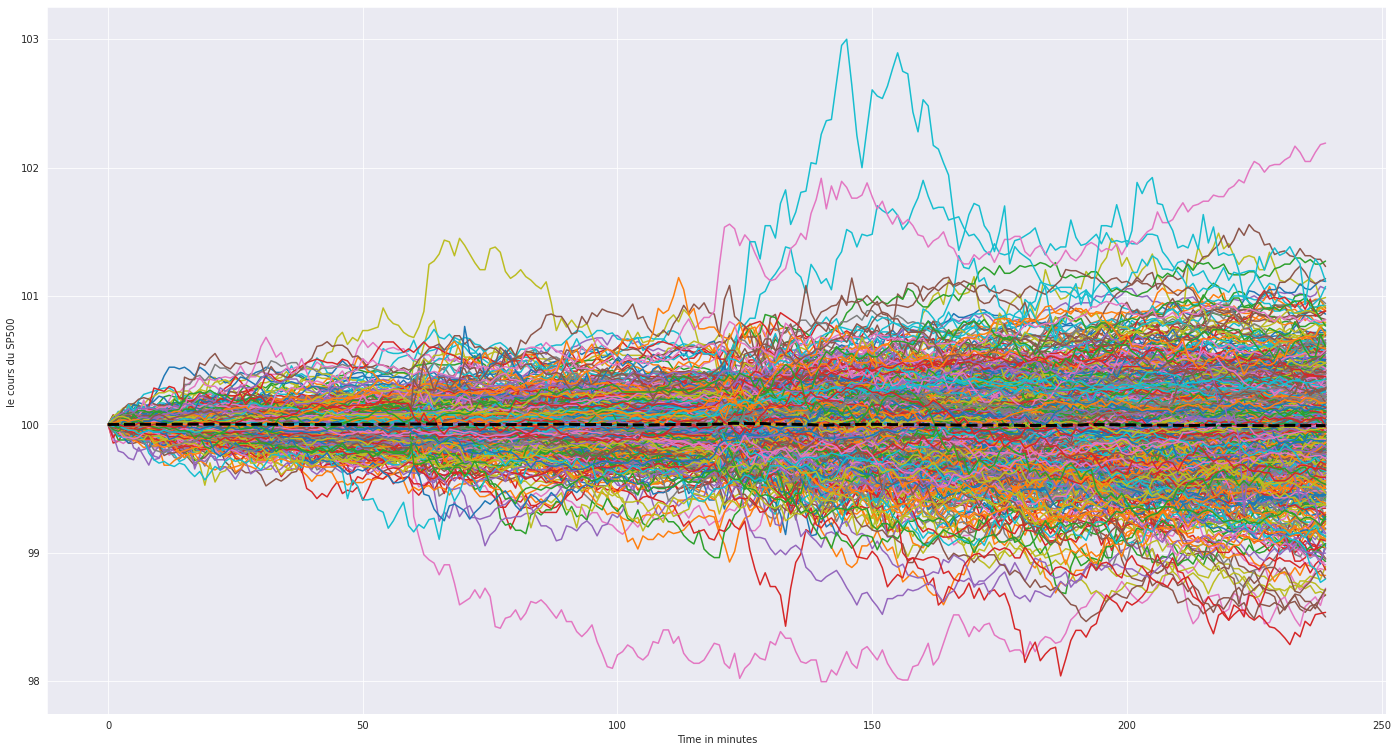

In [0]:
#plot(sp_train.values.T[2:-1,:].mean(axis = 1), ls = "--", lw= 20)
plot(sp_train.values.T[2:-1,:]);
plot(sp_train.values.T[2:-1,:].mean(axis = 1),color = "black", ls = "--", lw= 3)
xlabel("Time in minutes")
ylabel("le cours du SP500 ")

### Data normalisation

In [0]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
x_scaled = scaler.fit_transform(sp_train)

In [0]:
x = x_scaled.reshape(-1,243,1); x[:2]

In [0]:
df_processed = pd.DataFrame(df_filled, columns=df_train.columns); 
df_processed["exchange"] = df_train["exchange"] # categorical
df_processed["sector"]= df_train["sector"]  # categorical
df_processed["Target"] = sp_y_train; df_processed.head(3) 

In [0]:
from sklearn.model_selection import train_test_split

train_df, test_df = train_test_split(x_scaled, test_size=0.2)
train_df, val_df = train_test_split(train_df, test_size=0.2)


In [0]:
model = build_MLP( input_shape = (243,), activation = 'relu', units = [200,100],
                  momentum=0.1, epsilon=1e-05, dropout_rate = 0.3)

In [0]:
hist = model.fit(sp_train,sp_y_train,batch_size=30, epochs=10)

Epoch 1/10
914/914 [==============================] - 0s 213us/step - loss: 8.5893 - accuracy: 0.4398
Epoch 2/10
914/914 [==============================] - 0s 207us/step - loss: 8.5893 - accuracy: 0.4398
Epoch 3/10
914/914 [==============================] - 0s 204us/step - loss: 8.5893 - accuracy: 0.4398
Epoch 4/10
914/914 [==============================] - 0s 193us/step - loss: 8.5893 - accuracy: 0.4398
Epoch 5/10
914/914 [==============================] - 0s 197us/step - loss: 8.5893 - accuracy: 0.4398
Epoch 6/10
914/914 [==============================] - 0s 202us/step - loss: 8.5893 - accuracy: 0.4398
Epoch 7/10
914/914 [==============================] - 0s 209us/step - loss: 8.5893 - accuracy: 0.4398
Epoch 8/10
914/914 [==============================] - 0s 205us/step - loss: 8.5893 - accuracy: 0.4398
Epoch 9/10
914/914 [==============================] - 0s 197us/step - loss: 8.5893 - accuracy: 0.4398
Epoch 10/10
914/914 [==============================] - 0s 199us/step - loss: 8.589

## Fastai API for tabular data

In [0]:
from fastai.tabular import *

In [0]:
df = df_train

In [0]:
dep_var = 'Target'
cat_names = []
cont_names = sp_train.columns
procs = [FillMissing, Categorify, Normalize]

In [0]:
test = TabularList.from_df(df.iloc[600:914].copy(), cat_names=cat_names, cont_names=cont_names)

In [0]:
data = (TabularList.from_df(df, cat_names=cat_names, cont_names=cont_names, procs=procs)
                           .split_by_idx(list(range(600,914)))
                           .label_from_df(cols=dep_var)
                           #.add_test(test)
                           .databunch())

In [0]:
data.show_batch(rows=10)

openGammaCall,openGammaPut,closeMin001,closeMin002,closeMin003,closeMin004,closeMin005,closeMin006,closeMin007,closeMin008,closeMin009,closeMin010,closeMin011,closeMin012,closeMin013,closeMin014,closeMin015,closeMin016,closeMin017,closeMin018,closeMin019,closeMin020,closeMin021,closeMin022,closeMin023,closeMin024,closeMin025,closeMin026,closeMin027,closeMin028,closeMin029,closeMin030,closeMin031,closeMin032,closeMin033,closeMin034,closeMin035,closeMin036,closeMin037,closeMin038,closeMin039,closeMin040,closeMin041,closeMin042,closeMin043,closeMin044,closeMin045,closeMin046,closeMin047,closeMin048,closeMin049,closeMin050,closeMin051,closeMin052,closeMin053,closeMin054,closeMin055,closeMin056,closeMin057,closeMin058,closeMin059,closeMin060,closeMin061,closeMin062,closeMin063,closeMin064,closeMin065,closeMin066,closeMin067,closeMin068,closeMin069,closeMin070,closeMin071,closeMin072,closeMin073,closeMin074,closeMin075,closeMin076,closeMin077,closeMin078,closeMin079,closeMin080,closeMin081,closeMin082,closeMin083,closeMin084,closeMin085,closeMin086,closeMin087,closeMin088,closeMin089,closeMin090,closeMin091,closeMin092,closeMin093,closeMin094,closeMin095,closeMin096,closeMin097,closeMin098,closeMin099,closeMin100,closeMin101,closeMin102,closeMin103,closeMin104,closeMin105,closeMin106,closeMin107,closeMin108,closeMin109,closeMin110,closeMin111,closeMin112,closeMin113,closeMin114,closeMin115,closeMin116,closeMin117,closeMin118,closeMin119,closeMin120,closeMin121,closeMin122,closeMin123,closeMin124,closeMin125,closeMin126,closeMin127,closeMin128,closeMin129,closeMin130,closeMin131,closeMin132,closeMin133,closeMin134,closeMin135,closeMin136,closeMin137,closeMin138,closeMin139,closeMin140,closeMin141,closeMin142,closeMin143,closeMin144,closeMin145,closeMin146,closeMin147,closeMin148,closeMin149,closeMin150,closeMin151,closeMin152,closeMin153,closeMin154,closeMin155,closeMin156,closeMin157,closeMin158,closeMin159,closeMin160,closeMin161,closeMin162,closeMin163,closeMin164,closeMin165,closeMin166,closeMin167,closeMin168,closeMin169,closeMin170,closeMin171,closeMin172,closeMin173,closeMin174,closeMin175,closeMin176,closeMin177,closeMin178,closeMin179,closeMin180,closeMin181,closeMin182,closeMin183,closeMin184,closeMin185,closeMin186,closeMin187,closeMin188,closeMin189,closeMin190,closeMin191,closeMin192,closeMin193,closeMin194,closeMin195,closeMin196,closeMin197,closeMin198,closeMin199,closeMin200,closeMin201,closeMin202,closeMin203,closeMin204,closeMin205,closeMin206,closeMin207,closeMin208,closeMin209,closeMin210,closeMin211,closeMin212,closeMin213,closeMin214,closeMin215,closeMin216,closeMin217,closeMin218,closeMin219,closeMin220,closeMin221,closeMin222,closeMin223,closeMin224,closeMin225,closeMin226,closeMin227,closeMin228,closeMin229,closeMin230,closeMin231,closeMin232,closeMin233,closeMin234,closeMin235,closeMin236,closeMin237,closeMin238,closeMin239,closeMin240,Target,target
-0.4161,-1.1274,0.0000,1.2545,1.4783,1.6613,1.4168,0.6300,0.8655,0.5617,0.2418,0.2118,0.6362,0.6115,0.5677,0.5278,0.9116,0.5016,0.6748,0.8217,0.7815,0.6162,0.7580,0.7509,1.0585,0.8932,0.7278,1.0022,0.9869,0.9946,1.1212,1.2068,1.1773,1.1605,1.0250,1.1517,1.2538,0.9814,0.9571,0.9542,0.9499,0.8172,0.8009,0.7900,0.7903,0.6624,0.4149,0.5186,0.7279,0.6344,0.6290,0.9227,0.9039,0.9121,0.8036,0.8029,0.7793,0.8821,1.0758,1.0662,1.0694,1.0703,0.8879,0.9386,1.0503,0.9971,1.0471,1.0294,1.0322,1.0364,0.9619,0.9152,0.9157,0.9248,1.0718,0.9241,1.0674,0.8209,0.8070,0.9343,0.8804,0.9535,0.8772,0.8658,1.1441,1.2736,1.2051,1.3459,1.2625,1.1305,1.1327,1.1472,1.3386,1.3339,1.5248,1.6625,1.7871,2.0491,2.0220,2.2273,2.1569,2.0784,2.0802,2.0237,2.0022,2.0686,1.9859,1.9406,1.9470,1.9650,1.9560,1.8915,1.8818,1.8025,1.7310,1.6417,1.5623,1.5699,1.7046,1.5655,1.5714,1.6189,1.5228,1.5201,1.6656,1.4263,1.6611,1.5134,1.2167,0.9877,1.0612,1.0995,1.0611,0.7987,0.9549,0.8440,1.0994,0.9919,0.8444,0.9429,0.9322,0.8394,0.9972,0.9947,1.0406,1.2011,1.1985,1.3302,1.2787,1.1765,1.0852,1.1155,0.9941,1.0957

In [0]:
learn = tabular_learner(data, layers=[200,100], metrics=accuracy)

In [0]:
learn.fit(10, 1e-2)

epoch,train_loss,valid_loss,accuracy,time
0,0.479961,0.526335,0.799363,00:00
1,0.311117,0.081639,0.977707,00:00
2,0.223599,0.176661,0.936306,00:00
3,0.184586,0.052629,0.971338,00:00
4,0.143433,0.073473,0.984076,00:00
5,0.113916,0.078807,0.980892,00:00
6,0.094956,0.114374,0.955414,00:00
7,0.077320,0.062629,0.977707,00:00
8,0.065385,0.035062,0.993631,00:00
9,0.055308,0.002578,1.000000,00:00


## Convolutionnal network based model

In [0]:
from keras.layers import *
import keras

In [0]:

cnn = build_CNN(input_shape = (243,1), filters = [30,30], kernels = [4,4])
cnn.summary()
hist = cnn.fit(x,sp_y_train,batch_size=40, epochs=200)


Model: "sequential_42"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
batch_normalization_58 (Batc (None, 243, 1)            972       
_________________________________________________________________
conv1d_39 (Conv1D)           (None, 240, 3)            15        
_________________________________________________________________
batch_normalization_59 (Batc (None, 240, 3)            960       
_________________________________________________________________
dropout_57 (Dropout)         (None, 240, 3)            0         
_________________________________________________________________
conv1d_40 (Conv1D)           (None, 237, 30)           390       
_________________________________________________________________
max_pooling1d_18 (MaxPooling (None, 118, 30)           0         
_________________________________________________________________
batch_normalization_60 (Batc (None, 118, 30)         

## Conv_LSTM based model

In [0]:
def lstm_block( activation = 'relu', units = [100,100, 1], momentum=0.1, epsilon=1e-05,dropout_rate = 0.3 ):
    layers = []
    for n_units in units:
        
        layers.append(Dropout(dropout_rate))
        layers.append(LSTM(units=n_units,  activation=activation, recurrent_activation="sigmoid", return_sequences=True ))
    
    return layers

In [0]:
model = keras.models.Sequential(cnn.layers[:-4]+lstm_block( activation = 'tanh', units = [50,10])
      + [Flatten(), Dense(units=1, activation='sigmoid')])


In [0]:
model.compile(loss='binary_crossentropy',
              optimizer="adam",
              metrics=["accuracy"])
hist = model.fit(x,sp_y_train,batch_size=30, epochs=20)

In [0]:
hist = cnn.fit(x,sp_y_train,batch_size=40, epochs=200)


In [0]:
def lstm_block( activation = 'relu', units = [100,100, 1], momentum=0.1, epsilon=1e-05,dropout_rate = 0.3 ):
    layers = []
    for n_units in units:
        
        layers.append(tf.keras.layers.Dropout(dropout_rate))
        layers.append(tf.keras.layers.LSTM(units=n_units,  activation=activation, return_sequences=True ))
    
    return layers

In [0]:
model = tf.keras.models.Sequential(
    [tf.keras.layers.InputLayer(input_shape=(None, 1))] +
    conv1d_bolck(filters = [30,30], kernels = [4,4], stride = 1,  activation = 'relu', 
                  dropout_rate = 0.3) + [tf.keras.layers.MaxPooling1D()]+
    lstm_block( activation = 'tanh', units = [200,100]) +
    dense_block( activation = 'relu', units = [10,10,], dropout_rate = 0.3) +
    [tf.keras.layers.Dense(units=1, activation='sigmoid')]
)


model.summary()

lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-8 * 10**(epoch / 20))
optimizer = tf.keras.optimizers.SGD(lr=1e-8, momentum=0.9)
#optimizer = keras.optimizers.Nadam(
 #   learning_rate=1e-2, beta_1=0.9, beta_2=0.999, epsilon=1e-07)

model.compile(loss='binary_crossentropy',
              optimizer="adam",
              metrics=["accuracy"])
history = model.fit(x,sp_y_train,batch_size=30, epochs=200) #, callbacks=[lr_schedule])

In [0]:
history = model.fit(x,sp_y_train,batch_size=100, epochs=100)

Epoch 1/100
10/10 [==============================] - 0s 34ms/step - loss: 0.2857 - accuracy: 0.9126
Epoch 2/100
10/10 [==============================] - 0s 25ms/step - loss: 0.1614 - accuracy: 0.9213
Epoch 3/100
10/10 [==============================] - 0s 24ms/step - loss: 0.1717 - accuracy: 0.9206
Epoch 4/100
10/10 [==============================] - 0s 24ms/step - loss: 0.1590 - accuracy: 0.9202
Epoch 5/100
10/10 [==============================] - 0s 24ms/step - loss: 0.1527 - accuracy: 0.9243
Epoch 6/100
10/10 [==============================] - 0s 24ms/step - loss: 0.1799 - accuracy: 0.9207
Epoch 7/100
10/10 [==============================] - 0s 24ms/step - loss: 0.1780 - accuracy: 0.9171
Epoch 8/100
10/10 [==============================] - 0s 24ms/step - loss: 0.1683 - accuracy: 0.9167
Epoch 9/100
10/10 [==============================] - 0s 25ms/step - loss: 0.1617 - accuracy: 0.9238
Epoch 10/100
10/10 [==============================] - 0s 24ms/step - loss: 0.1732 - accuracy: 0.9211

In [0]:
plt.semilogx(history.history["lr"], history.history["loss"])
plt.axis([1e-8, 1e-2, 0, 60])

## Time séries forcasting

In [0]:
ts_data = x[:,2:, 0].T

Text(0, 0.5, 'le cours du SP500 ')

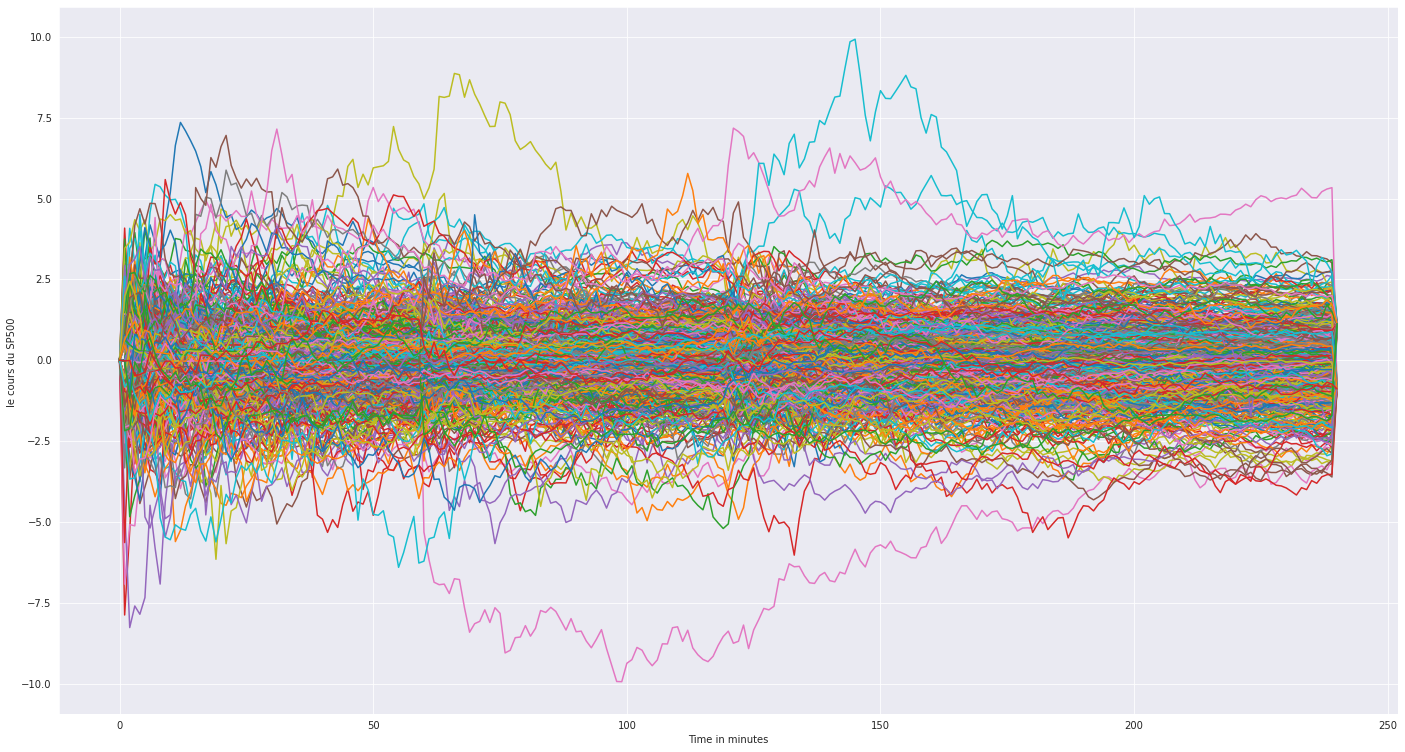

In [0]:
plot(ts_data);
xlabel("Time in minutes")
ylabel("le cours du SP500 ")

In [0]:
ts_data.shape

(1, 241, 914)

In [0]:
def windowed_dataset2(series):
    series = tf.expand_dims(series, axis=-1)
    ds = tf.data.Dataset.from_tensor_slices(series)
    
    ds = ds.map(lambda w: (w[:-1], w[1:]))
    return ds.batch(241).prefetch(1)

In [0]:
windowed_dataset2(ts_data)

In [0]:
import tensorflow as tf

In [0]:
a = np.array([[1,2,3],[4,5,6],[7,8,9], [10,11,12]]); a.shape

(4, 3)

In [0]:
sd = windowed_dataset2(a); sd

<PrefetchDataset shapes: ((None, 2, 1), (None, 2, 1)), types: (tf.int64, tf.int64)>